## Step 3: Client SLA Definition

This notebook defines **client Service Level Agreements (SLAs)** for worker performance.  
We will:
1. Set fixed SLA thresholds for **accuracy** and **task count** based on client expectations.  
2. Evaluate **SLA compliance** at worker and daily levels.  
3. Identify initial **gaps in SLA adherence** to guide further statistical calibration.


In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load the synthetic dataset
df = pd.read_csv("simulated_worker_tasks.csv", parse_dates=["task_date"])
df.head()

,task_id,worker_id,task_date,task_complexity,time_taken_minutes,accuracy
0,77016b53-3aa3-497a-b042-4246e5a9583e,W_001,2024-01-01,Low,5.28,0.990
1,7f65a185-9675-4d6d-974c-c0b27805270a,W_001,2024-01-01,Medium,7.30,0.946
2,a78aa64d-4a37-4105-baab-125b5d293c4e,W_001,2024-01-01,Low,4.43,0.952
3,2d08d6c7-c351-40f4-af67-5a62f3a250ce,W_001,2024-01-01,Medium,5.41,0.913
4,c236a814-63f0-4035-8e30-b4642282a1d8,W_001,2024-01-01,Medium,7.36,0.908


## Define Fixed Client SLAs

Assumptions for client expectations:
- **Accuracy SLA:** ≥ 95% (0.95)
- **Daily Task Count SLA:** ≥ 20 tasks per worker per day

These fixed thresholds represent **business requirements**, independent of worker historical performance.

In [7]:
# Define SLA thresholds
ACCURACY_SLA = 0.95
TASK_COUNT_SLA = 20

## Evaluate SLA Compliance per Worker per Day

- Calculate **daily tasks completed** per worker.  
- Calculate **average accuracy** per worker per day.  
- Determine whether the worker **meets the SLA** for that day.

In [8]:
# Group by worker and date
daily_stats = df.groupby(['worker_id', 'task_date']).agg(
    tasks_completed=('task_id','count'),
    avg_accuracy=('accuracy','mean')
).reset_index()

# Evaluate SLA compliance
daily_stats['accuracy_sla_met'] = daily_stats['avg_accuracy'] >= ACCURACY_SLA
daily_stats['task_count_sla_met'] = daily_stats['tasks_completed'] >= TASK_COUNT_SLA
daily_stats['overall_sla_met'] = daily_stats['accuracy_sla_met'] & daily_stats['task_count_sla_met']

daily_stats.head()

,worker_id,task_date,tasks_completed,avg_accuracy,accuracy_sla_met,task_count_sla_met,overall_sla_met
0,W_001,2024-01-01,18,0.955167,True,False,False
1,W_001,2024-01-02,17,0.941176,False,False,False
2,W_001,2024-01-03,13,0.932769,False,False,False
3,W_001,2024-01-04,12,0.945667,False,False,False
4,W_001,2024-01-05,21,0.934905,False,True,False


## SLA Compliance Summary

- Calculate **percentage of days each worker met SLAs**.
- Identify **workers struggling to meet client expectations**.

In [9]:
sla_summary = daily_stats.groupby('worker_id').agg(
    total_days=('task_date','nunique'),
    days_accuracy_sla_met=('accuracy_sla_met','sum'),
    days_task_sla_met=('task_count_sla_met','sum'),
    days_overall_sla_met=('overall_sla_met','sum')
).reset_index()

# Calculate percentages
sla_summary['accuracy_sla_pct'] = (sla_summary['days_accuracy_sla_met']/sla_summary['total_days']*100).round(2)
sla_summary['task_sla_pct'] = (sla_summary['days_task_sla_met']/sla_summary['total_days']*100).round(2)
sla_summary['overall_sla_pct'] = (sla_summary['days_overall_sla_met']/sla_summary['total_days']*100).round(2)

sla_summary.head()

,worker_id,total_days,days_accuracy_sla_met,days_task_sla_met,days_overall_sla_met,accuracy_sla_pct,task_sla_pct,overall_sla_pct
0,W_001,30,6,3,0,20.00,10.00,0.00
1,W_002,30,6,3,1,20.00,10.00,3.33
2,W_003,30,8,2,1,26.67,6.67,3.33
3,W_004,30,4,4,0,13.33,13.33,0.00
4,W_005,30,5,0,0,16.67,0.00,0.00


## Visualize SLA Compliance

- **Accuracy SLA Compliance per Worker**
- **Task Count SLA Compliance per Worker**
- **Overall SLA Compliance**

C:\Users\admin\AppData\Local\Temp\ipykernel_17444\625966877.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sla_summary, x='worker_id', y='accuracy_sla_pct', palette='Blues_d')


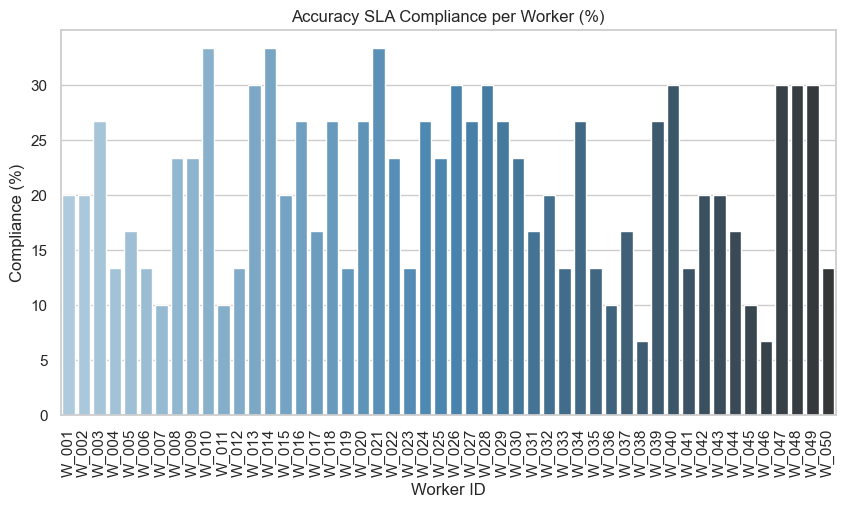

C:\Users\admin\AppData\Local\Temp\ipykernel_17444\625966877.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sla_summary, x='worker_id', y='task_sla_pct', palette='Greens_d')


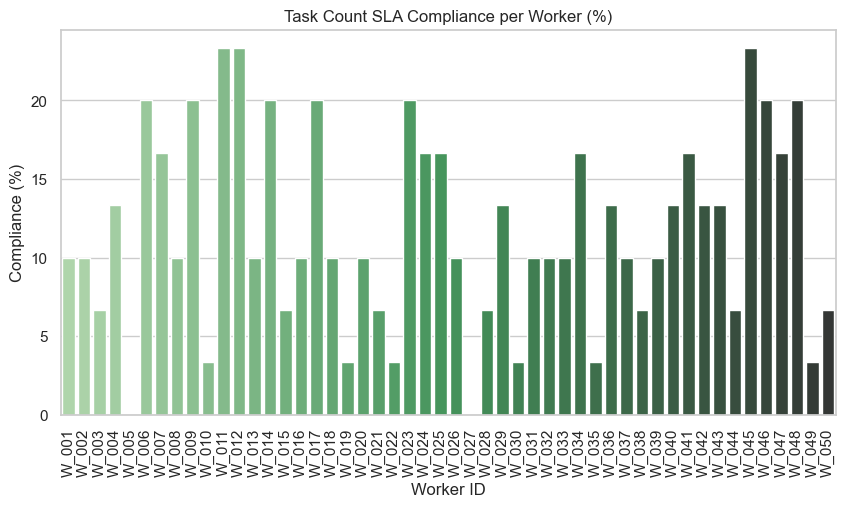

C:\Users\admin\AppData\Local\Temp\ipykernel_17444\625966877.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sla_summary, x='worker_id', y='overall_sla_pct', palette='Oranges_d')


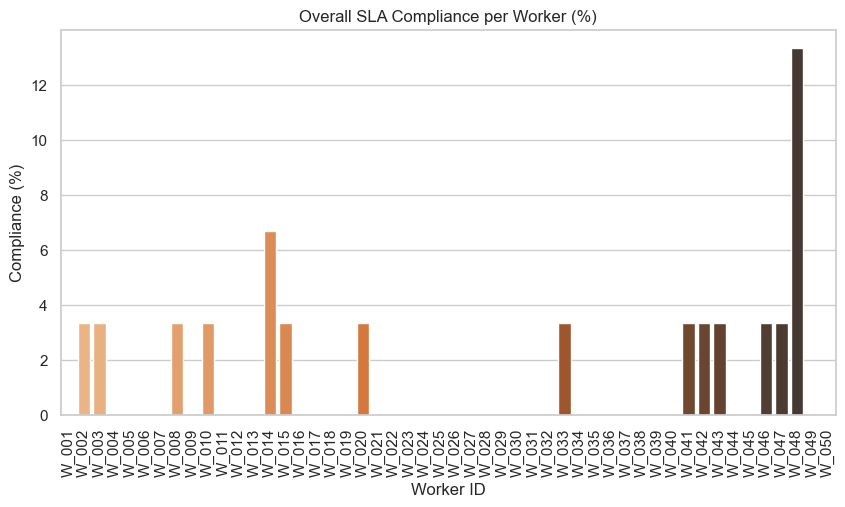

In [10]:
# Accuracy SLA compliance
plt.figure(figsize=(10,5))
sns.barplot(data=sla_summary, x='worker_id', y='accuracy_sla_pct', palette='Blues_d')
plt.xticks(rotation=90)
plt.title("Accuracy SLA Compliance per Worker (%)")
plt.ylabel("Compliance (%)")
plt.xlabel("Worker ID")
plt.show()

# Task Count SLA compliance
plt.figure(figsize=(10,5))
sns.barplot(data=sla_summary, x='worker_id', y='task_sla_pct', palette='Greens_d')
plt.xticks(rotation=90)
plt.title("Task Count SLA Compliance per Worker (%)")
plt.ylabel("Compliance (%)")
plt.xlabel("Worker ID")
plt.show()

# Overall SLA compliance
plt.figure(figsize=(10,5))
sns.barplot(data=sla_summary, x='worker_id', y='overall_sla_pct', palette='Oranges_d')
plt.xticks(rotation=90)
plt.title("Overall SLA Compliance per Worker (%)")
plt.ylabel("Compliance (%)")
plt.xlabel("Worker ID")
plt.show()


## Key Observations

1. Some workers consistently meet **accuracy SLA** but fail **task count SLA**.  
2. Certain workers struggle with both, highlighting **training or workload adjustment needs**.  
3. Fixed client SLAs provide a **baseline for evaluating workforce performance** before statistical calibration.  
4. These insights guide the next step: **Statistical SLA Calibration based on historical trends**.